In [ ]:
from libs import *
pd.set_option('display.max_rows', 100)

# Model Building
<a id='contents'></a>
We can now build the machine learning model that classifies Reddit posts into the nine categories we defined earlier. This notebook takes you through the following stages of model construction. 

1. [Load labelled data](#section1)
2. [Train / Test split](#section2)
3. [Apply cleaning / transformation](#section3)
4. [Train models](#section4)
5. [Cross-validation and optimize hyperparameters](#section5)
6. [Other Models](#section6)

<a id='section1'></a>
## 1. Load labelled data
[back](#contents)

We read the dataset containing the following labels for training / prediction:

In [ ]:
df = pd.read_csv('datasets/all_reddit_labelled.csv')

In [ ]:
TARGET = 'label'
LABELS = ['screeners', 
          'bad test', 
          'ratings', 
          'recorder', 
          'live convo', 
          'no test', 
          'mobile', 
          'bug', 
          'payment']

In [ ]:
from helpers import DatasetCreator

This helper class removes the NaNs and concatenate the texts in each post:

In [86]:
creator = DatasetCreator(cols_to_drop_na=TARGET, train=True, labels=LABELS)
data = creator.transform(df)

In [87]:
data.head()

,title,score,num_comments,created_at,text,label
793,"Just took a 5 minute survey, and didnâ€™t real...",2,5,2019-07-20 10:41:00,"Just took a 5 minute survey, and didnâ€™t real...",ratings
792,"No tests received, ever",4,5,2019-07-20 21:15:00,"No tests received, ever Iâ€™ve had usertesting...",no test
790,"Any Australians here? As an Aussie myself, i w...",2,9,2019-07-22 23:45:00,"Any Australians here? As an Aussie myself, i w...",screeners
789,Only 2 ratings. 4 star and just got 2 star. 2 ...,3,4,2019-07-23 04:19:00,Only 2 ratings. 4 star and just got 2 star. 2 ...,ratings
788,Almost a month since a live test and still no pay,3,5,2019-07-23 07:01:00,Almost a month since a live test and still no ...,payment


### Explore the labels
Are the classes balanced (i.e. do we have roughly the same number of items in each category?)

In [88]:
data[TARGET].value_counts()

screeners     78
bad test      72
recorder      71
ratings       70
live convo    57
mobile        53
no test       53
bug           40
payment       33
Name: label, dtype: int64

## 2. Train-Test Split
<a id="section2"></a>[back](#contents)

This is used so we can estimate the performance of machine learning algorithms when they make predictions on data that were not used to train the model. What normally happens is that we keep the test data separate and don't touch it until we are happy with the performance of the model on the training set.

<img src="figures/train_test_split.png" width=500>

* **Train Dataset**: Used to fit the machine learning model.
* **Test Dataset**: Used to evaluate the fitted machine learning model.

#### Cross-validation
When our dataset is small, we can use *k*-fold cross-validation to evaluate performance: we divide the training data into *k* parts, train on *k-1* parts and evaluate on the remaining part. ([See later](#hyper)) <a id="cv"></a>

In [ ]:
from sklearn.model_selection import train_test_split

We specify the `stratify` keyword because our data is not balanced - this allows us to retain the same ratios of the categories in the test set as in the training set

In [89]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data[TARGET])

In [90]:
train_df[TARGET].value_counts()

screeners     62
bad test      58
recorder      57
ratings       56
live convo    46
mobile        42
no test       42
bug           32
payment       26
Name: label, dtype: int64

In [91]:
test_df[TARGET].value_counts()

screeners     16
recorder      14
ratings       14
bad test      14
mobile        11
live convo    11
no test       11
bug            8
payment        7
Name: label, dtype: int64

In [98]:
y_train = train_df[TARGET]
X_train = train_df.drop(columns=TARGET, axis=1)

y_test = test_df[TARGET]
X_test = test_df.drop(columns=TARGET, axis=1)

## 3. Apply cleaning / vectorization 
<a id='section3'></a>[back](#contents)

We make use of Simon's text cleaning / vectorizer code in a scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). This sequentially applies the text cleaning and vectorizing to create a sparse matrix that can be used as input. In this case we use a vocabulary of the top 1500 tokens, so we have a matrix of dimension `(1500, n_train)`, because most of the text will only contain a few tokens.

In [ ]:
from pipeline import vectorizer_pipe

In [99]:
vectorizer_pipe.fit(X_train, y_train)
X_train = vectorizer_pipe.transform(X_train)

In [ ]:
feature_names = vectorizer_pipe.named_steps['vectorizer'].get_feature_names()
feature_names[:10]

In [ ]:
X_train.toarray()

In [102]:
X_test = vectorizer_pipe.transform(X_test)

## 4. Train Models
<a id="section4"></a>[back](#contents)

Now we've got our data sorted, we can start training models.

We look at some of the more commonly used machine learning algorithms. We will be making extensive use of the [scikit-learn](https://scikit-learn.org/stable/index.html) library, one of the most popular machine learning libraries for Python.

Before we get started, we need to define success criteria: here we have a multi-class classification problem, so one obvious metrics is accuracy. Another is called the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which provides a good way of inspecting prediction errors.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate(clf, plot=True):
    """Evaluate test set performance"""
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model accuracy on test set = {accuracy}')
    
    if plot:
        # Compute ane plot confusion matrix as heatmap
        cf = confusion_matrix(y_test, y_pred)
        df_cf = pd.DataFrame(cf, columns=clf.classes_, index=clf.classes_)
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(df_cf, ax=ax, annot=True, cmap='Blues')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    return accuracy

    
def evaluate_train(clf):
    """Compute training set accuracy score"""
    y_pred = clf.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    print(f'Model accuracy on training set = {accuracy}')

### [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* Pros: Easy to train, easy to interpret
* Cons: Easy to overfit

<img src="figures/decision_tree.png">

In [ ]:
from sklearn import tree
params = {'max_depth': 15, 'class_weight': 'balanced', 'random_state':42} # Random state is needed for reproducibility!
clf = tree.DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)

In [ ]:
evaluate_train(clf)

In [ ]:
evaluate(clf, plot=True)

In [ ]:
clf.get_params()

Model performs much better on training set than test set. This is called *overfitting*. Essentially the model has 'memorized' the training data and is not learning any more. 

### [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#)

This is an ensemble learning method for classification 
* Operate by constructing a multitude of decision trees at training time 
* Output the class that is the mode of the classes (classification) of the individual trees
* Correct the tendency of decision trees to overfit

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
params = {'n_estimators':100, 'random_state':42, 'max_depth':10, 'class_weight':'balanced'}
rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

Evaluate the [performance](#eval2) of the Random Forest model: <a id='eval1'></a>

Model accuracy on test set = 0.7169811320754716


0.7169811320754716

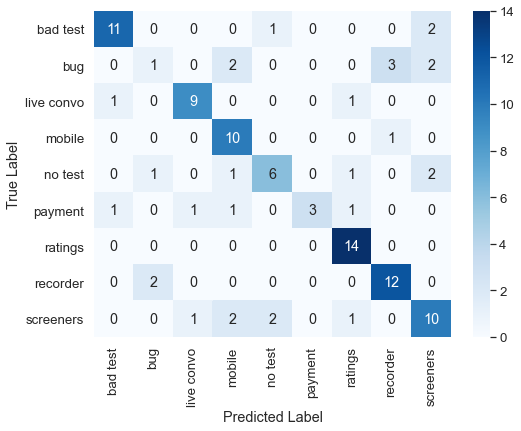

In [105]:
performance = evaluate(rf_clf)
performance

There are a lot of interesting things you can look at in the random forest model, e.g. the most important features (in this case, tokens):

In [ ]:
features = vectorizer_pipe.named_steps['vectorizer'].get_feature_names() # The names (tokens are give in the last step of the pipeline)
feature_importances = rf_clf.feature_importances_

most_important_features = pd.DataFrame(zip(features, feature_importances), 
                                  columns=['features', 'importances']).sort_values(by='importances', ascending=False)

In [ ]:
most_important_features[:10]

## 5. Cross-Validation and Hyper-parameter Tuning
<a id="section5"></a>[back](#contents)

Most of the models come with a set of adjustable parameters (or hyper-parameters) that can significantly modify the performance of the model. Some of the important parameters for the models above are: 

**Decision Trees**:
- The depth of the tree: the deeper the tree, the more likely to overfit

**Random Forest**:
- Number of trees in the ensemble (`n_estimators`) - too many trees can lead to overfitting as well
- Number of features considered by each tree when splitting a node (`max_features`)
- Depth of the trees (`max_depth`)

<img src="figures/hyperparameter_tuning.png">

We want to identify the set of hyperparameters that will yield the highest performing model.

### Random Search Cross Validation 
<a id="hyperparameter"></a>
Remember the [figure](#cv) from section 2. We use the `RandomizedSearchCV` method in scikit-learn to sample from a grid of hyperparameter ranges, and performing *k*-fold cross-validation with each combination of values.

In [ ]:
# Look at the parameters that are currently used:
rf_clf.get_params()

Create the parameter grid to sample from during fitting:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'class_weight': ['balanced']}
pprint(random_grid)

### Random Search
Use the random grid to search for best hyperparameters:

In [ ]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
best_random = rf_random.best_estimator_
random_performance = evaluate(best_random)

<a id='eval2'></a>
We can compared with the [original model](#eval1) to see whether random hyperparameter tuning has improved things.

We haven't tried very hard. Generally, random search allows us to narrow down the range of each hyperparameter, after which we can explicitly specify every combination of parameters to try. This is called [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), and can takes a *very* long time, so use it with caution.

In [100]:
rf_clf = RandomForestClassifier(**rf_random.best_params_, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_leaf=4, n_estimators=180, random_state=42)

Model accuracy on test set = 0.6981132075471698


0.6981132075471698

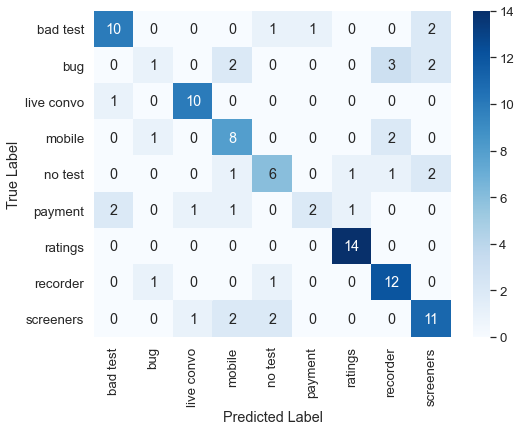

In [103]:
evaluate(rf_clf)

## 6. Other Machine Learning Models
<a id="section6"></a>
[back](#contents)

There are _many_ machine learning models for classification besides what we have discussed. We list some here, and note that each of them have their strengths and shortcomings - SVMs for examples are slow to train, while linear models usually have sub-par performance.
- [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html#)
- [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)...

The nice thing is that since scikit-learn estimators have a uniform API, so it's easy to try these out on your own and look at their performance - here we simply use the default hyperparameters since they usually give reasonable results.

In [ ]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def train_evaluate_model(model):
    clf = model() 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'accuracy_score of f{str(model)} = {accuracy_score(y_test, y_pred)}')

In [ ]:
train_evaluate_model(Perceptron)

In [ ]:
train_evaluate_model(LinearSVC)

In [ ]:
train_evaluate_model(Perceptron)

In [ ]:
train_evaluate_model(MultinomialNB)

In [ ]:
train_evaluate_model(GradientBoostingClassifier)

### Save models and data

In [106]:
joblib.dump(vectorizer_pipe, 'trained_models/vectorizer_pipe.pkl')
joblib.dump(rf_clf, 'trained_models/random_forest_classifier.pkl')

['trained_models/random_forest_classifier.pkl']

In [ ]:
joblib.dump(X_test, 'datasets/X_test.pkl')
joblib.dump(y_test, 'datasets/y_test.pkl')